# Imports and funtions

In [342]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.stats.multitest as mt
from gtda.homology import WeakAlphaPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance

In [344]:
def filter_dgm(dgm, alpha, log = True):
    m = slope(dgm, alpha)
    if log:
        dgm_log = log_dgm(dgm)
        filtered_dgm = [(z, (x,y)) for (z,(x,y)) in dgm_log if y > np.log(m)+x]
    else:
        filtered_dgm = [(z, (x,y)) for (z,(x,y)) in dgm if y > m*x]
    return filtered_dgm

def log_dgm(dgm):
    return [(z, (np.log(x), np.log(y))) for (z,(x,y)) in dgm]

def circles3_point_cloud(noise):
    # Parameters for the circles
    num_points = 100  # Number of points in each circle
    radius = 1.0  # Radius of the circles
    offsets = [(-2, 0), (0, 0), (2, 0)]  # Offsets for the centers of the circles

    # Generate points for each circle
    circle_points = []
    for offset in offsets:
        x_center, y_center = offset
        theta = np.linspace(0, 2*np.pi, num_points)
        x_circle = x_center + radius * np.cos(theta)
        y_circle = y_center + radius * np.sin(theta)
        circle_points.append(np.vstack((x_circle, y_circle)).T)

    # Combine points from all circles
    point_cloud = np.vstack(circle_points) + np.random.normal(0, noise, (3*num_points, 2))
    return point_cloud

def gtda_to_gudhi(dgm):
    return [(int(z), (x,y)) for [x,y,z] in dgm]

def gudhi_to_gtda(dgm):
    return np.array([[x,y,z] for z, (x,y) in dgm])

GUMBEL = st.gumbel_l()


# Ratio of lifetimes: death / birth
def pi(dgm):
    dgm = gudhi_to_gtda(dgm) # Convert to gtda format

    h1 = dgm[dgm[:, 2] == 1] # Get k = 1

    pi_p = h1[:, 1] / h1[:, 0] # d / b

    return np.array(pi_p)

# Mean of the log-log transform of the ratio of lifetimes
def L(dgm):
    pi_p  = pi(dgm)
    pi_p  = pi_p[pi_p > 1]

    L_bar = np.log(np.log(pi_p)).mean() # Log-log transform

    return np.array(L_bar)


# l(p) = A * log(log(pi(p))) + B
def l(dgm, A = 0.5):
    pi_p = pi(dgm)
    L_bar = L(dgm)

    B_h1 = - GUMBEL.mean() - A * L_bar.mean() # B = - lambda.mean() - A * L_bar

    l_p = A * np.log(np.log(pi_p)) + B_h1 # l(p) = A * log(log(pi(p))) + B

    return l_p

def test(dgm, alpha = 0.05): 
    dist = GUMBEL
    X = l(dgm) # l(p)
    pvals = 1 - dist.cdf(X) # Survival function (1 - cdf) : e^{-e^{(l(p)}}
    res, pv, c, calpha = mt.multipletests(pvals, alpha=alpha, method='bonferroni')  # dgm_s = p in dgm where that pvals < alpha/|dgm|
    return np.sum(res == True),res,calpha  

def slope(X,alpha,A=0.5): # Finds the slope of the line
    pi_p = pi(X) # pi(p)
    M = len(pi_p) # |dgm_k|
    L_bar = np.log(np.log(pi_p)).mean() # Log Log pi(p)
    B = - GUMBEL.mean() - A * L_bar # B = - lambda.mean() - A * P.mean()
    return np.exp(((-1) * np.exp(-B) * np.log(alpha/M))**(1/A)) # Slope is in log space?? 

# Creating point cloud

In [360]:
# Number of points per torus
num_points = 100

# Parameters for the toruses
radius_major = 2.0
radius_minor = 0.5
num_turns = 3

# Parametric equations for torus
u = np.linspace(0, 2*np.pi, num_points)
v = np.linspace(0, 2*np.pi, num_points)
U, V = np.meshgrid(u, v)
x = (radius_major + (radius_minor + np.random.normal(-0.5,0.5)) * np.cos(num_turns * U)) * np.cos(V)
y = (radius_major + (radius_minor + np.random.normal(-0.5,0.5)) * np.cos(num_turns * U)) * np.sin(V)

# Generate points for three toruses
x1, y1 = x.flatten(), y.flatten()
x2, y2 = x.flatten() + 4, y.flatten()
x3, y3 = x.flatten() - 4, y.flatten()

x = np.concatenate((x1, x2, x3)) + np.random.normal(0, 0.2, 3*num_points**2)
y = np.concatenate((y1, y2, y3)) + np.random.normal(0, 0.2, 3*num_points**2)


In [361]:
point_cloud_t = np.column_stack((x, y))

num_samples = 1000
indices = np.random.choice(point_cloud_t.shape[0], num_samples, replace=False)
point_cloud = point_cloud_t[indices]

alpha_complex = gd.AlphaComplex(points=point_cloud)
simplex_tree = alpha_complex.create_simplex_tree()

# Compute the persistence diagram of the alpha complex
dgm = simplex_tree.persistence()
dgm = [pt for pt in dgm if pt[0] == 1]

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

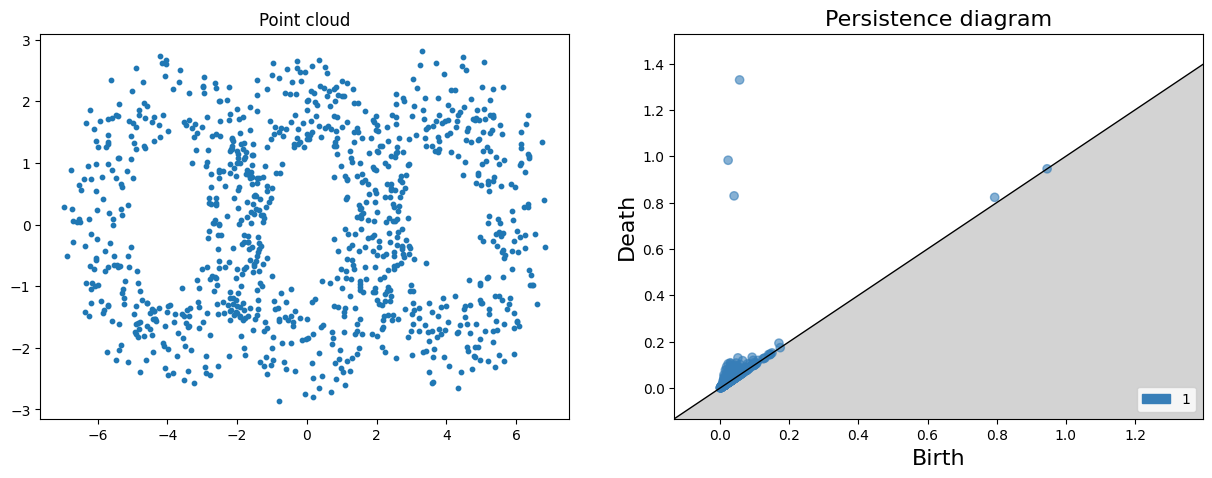

In [362]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(point_cloud[:, 0], point_cloud[:, 1], s=10)
ax[0].set_title('Point cloud')

gd.plot_persistence_diagram(dgm, axes=ax[1])



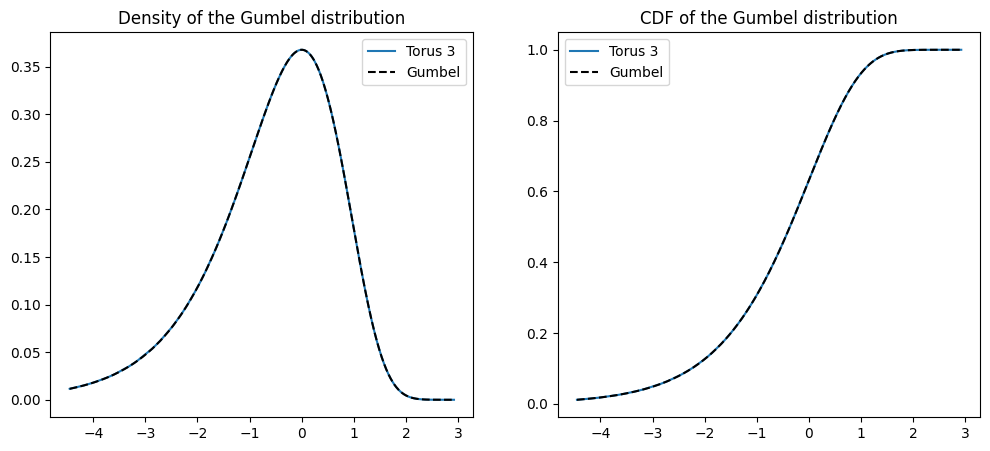

In [363]:
torus3_l = l(dgm)
# sort and plot 
torus3_l = np.sort(torus3_l)
x = np.linspace(np.min(torus3_l),np.max(torus3_l),1000)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(torus3_l, GUMBEL.pdf(torus3_l),label='Torus 3')
ax[0].plot(x, GUMBEL.pdf(x),label='Gumbel', c = 'black', linestyle='--')

ax[0].set_title('Density of the Gumbel distribution')
ax[0].legend()

ax[1].plot(torus3_l, GUMBEL.cdf(torus3_l),label='Torus 3')
ax[1].plot(x, GUMBEL.cdf(x),label='Gumbel', c = 'black', linestyle='--')
ax[1].set_title('CDF of the Gumbel distribution')
ax[1].legend()

plt.legend()



In [364]:
signals, res, alpha = test(dgm, alpha = 0.001)
print('Number of signals: ', signals)
print('alpha: ', alpha)

Number of signals:  3
alpha:  1.1402508551881415e-06


In [365]:
dgm_log = log_dgm(dgm)

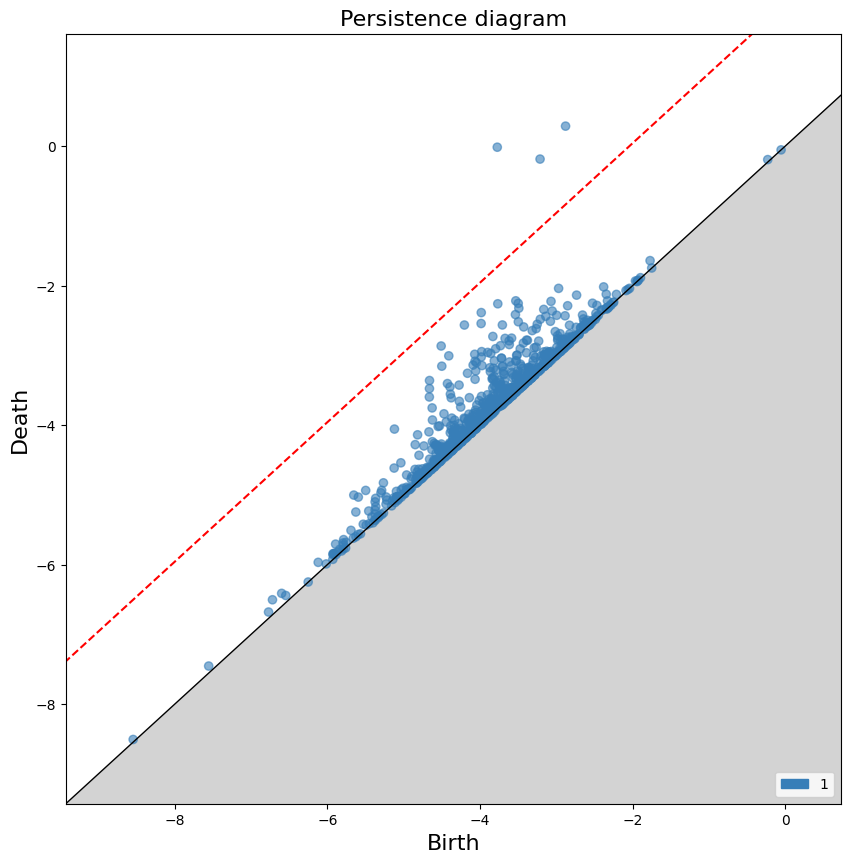

In [366]:
dgm_log = log_dgm(dgm)

fig, ax = plt.subplots(1, figsize=(10,10))

gd.plot_persistence_diagram(dgm_log, axes=ax)

m = slope(dgm, alpha = 0.001)

x = np.linspace(-100, 10, 1000)

plt.plot(x, x + np.log(m), c = 'red', linestyle='--')

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

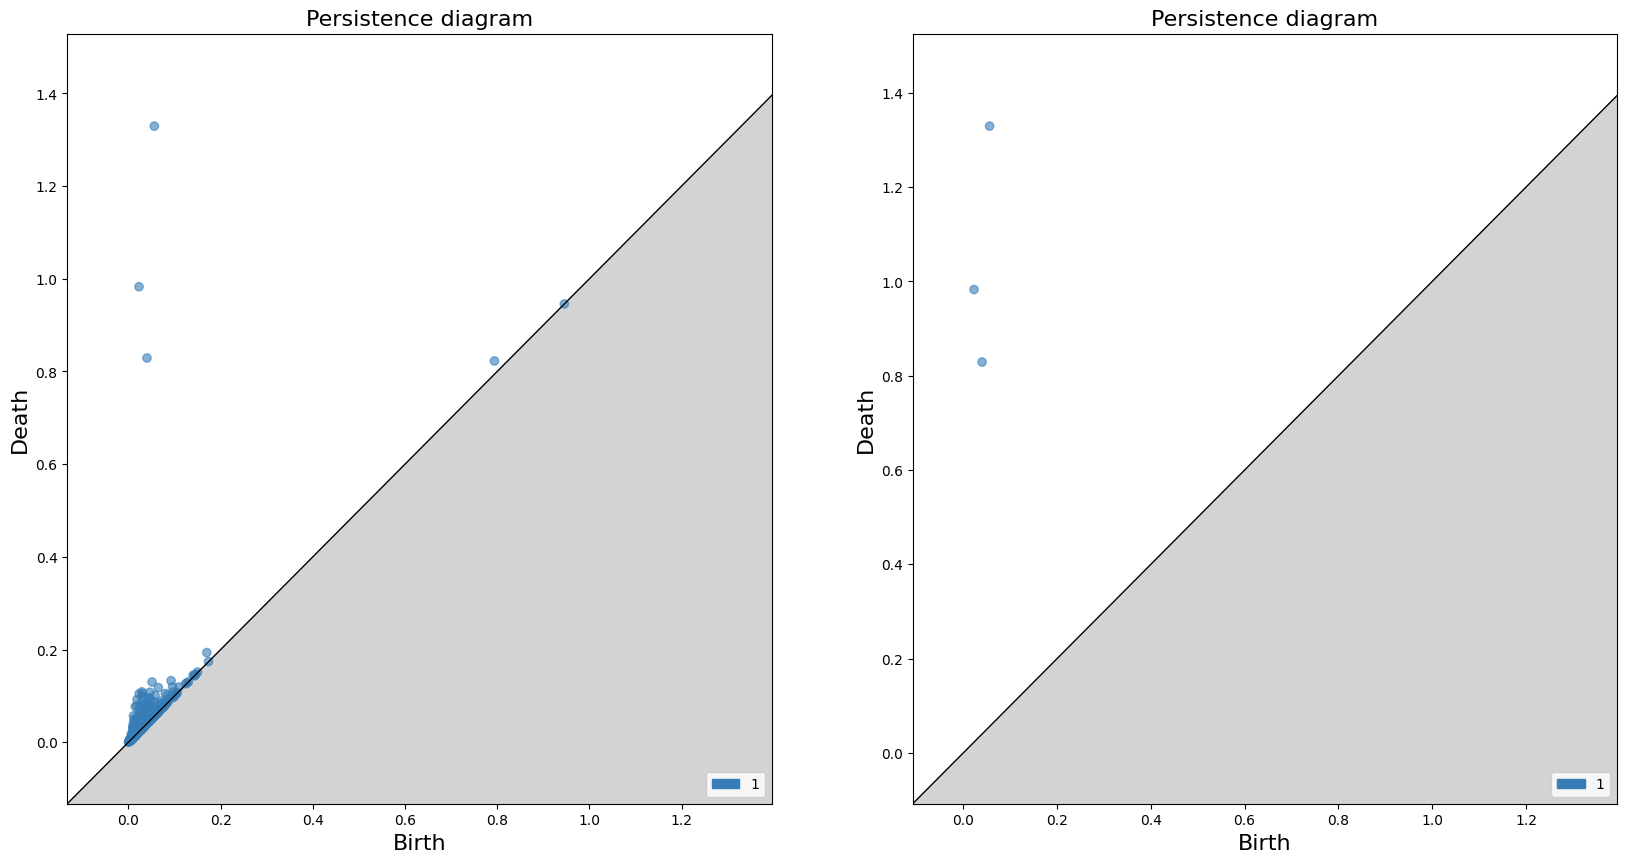

In [373]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

gd.plot_persistence_diagram(dgm, axes=ax[0])
gd.plot_persistence_diagram(filter_dgm(dgm,0.001,log=False), axes=ax[1])